In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, auc, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier,
                              StackingClassifier, AdaBoostClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import warnings

In [3]:
df = pd.read_csv("df.csv")
df_bin = pd.read_csv("df_bin.csv")
df_cut = pd.read_csv("df_cut.csv")
df_cut_bin = pd.read_csv("df_cut_bin.csv")

In [4]:
ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
print(ic50_columns)
ic50_columns = [col for col in df.columns if 'ic50' in col.lower()]
print(ic50_columns)
ic50_columns = [col for col in df_bin.columns if 'ic50' in col.lower()]
print(ic50_columns)

['IC50, mM', 'log_IC50']
['IC50, mM', 'log_IC50']
['IC50, mM', 'log_IC50']


In [5]:

median_ic50_1 = df['IC50, mM'].median()
df['IC50_above_median'] = (df['IC50, mM'] > median_ic50_1).astype(int)

median_ic50_2 = df_bin['IC50, mM'].median()
df_bin['IC50_above_median'] = (df_bin['IC50, mM'] > median_ic50_2).astype(int)

median_ic50_3 = df_cut['IC50, mM'].median()
df_cut['IC50_above_median'] = (df_cut['IC50, mM'] > median_ic50_3).astype(int)

median_ic50_4 = df_cut_bin['IC50, mM'].median()
df_cut_bin['IC50_above_median'] = (df_cut_bin['IC50, mM'] > median_ic50_4).astype(int)



Сравниваем разные модели

In [7]:
#df = df.drop(columns=['IC50, mM'])
df = df.drop(columns=['log_IC50'])
df = df.drop(columns=['SI'])
df_bin = df_bin.drop(columns=['log_IC50'])
#df_bin = df_bin.drop(columns=['IC50, mM'])
df_bin = df_bin.drop(columns=['SI'])
df_cut = df_cut.drop(columns=['log_IC50'])
#df_cut = df_cut.drop(columns=['IC50, mM'])
df_cut = df_cut.drop(columns=['SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_IC50'])
#df_cut_bin = df_cut_bin.drop(columns=['IC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['SI'])
df = df.drop(columns=['log_SI'])
df_bin = df_bin.drop(columns=['log_SI'])
df_cut = df_cut.drop(columns=['log_SI'])
df_cut_bin = df_cut_bin.drop(columns=['log_SI'])
df = df.drop(columns=['CC50, mM'])
df_bin = df_bin.drop(columns=['CC50, mM'])
df_cut = df_cut.drop(columns=['CC50, mM'])
df_cut_bin = df_cut_bin.drop(columns=['CC50, mM'])
df = df.drop(columns=['log_CC50'])
df_bin = df_bin.drop(columns=['log_CC50'])
df_cut = df_cut.drop(columns=['log_CC50'])
df_cut_bin = df_cut_bin.drop(columns=['log_CC50'])


In [8]:
ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
print(ic50_columns)

['IC50, mM', 'IC50_above_median']


In [36]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from matplotlib.backends.backend_pdf import PdfPages

# Очистка имен и замена inf на nan
for d in [df, df_cut, df_bin, df_cut_bin]:
    d.columns = d.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    d.replace([np.inf, -np.inf], np.nan, inplace=True)

# Определение базовых моделей классификации
estimators_cls = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('cat', CatBoostClassifier(verbose=0, random_state=42))
]

final_estimator_cls = LogisticRegression()
stacking_model_cls = StackingClassifier(
    estimators=estimators_cls,
    final_estimator=final_estimator_cls,
    cv=5,
    n_jobs=-1
)

class_models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(
        depth=6,
        iterations=100,
        l2_leaf_reg=5,
        learning_rate=0.05,
        verbose=0,
        random_state=42
    ),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "NaiveBayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Stacking": stacking_model_cls
}


def evaluate_class_models(df_input, ic50_col='IC50_mM'):
    df_eval = df_input.copy().drop(columns=['Unnamed_0'], errors='ignore')
    df_eval = df_eval.rename(columns={'IC50_mM': ic50_col, 'IC50__mM_': ic50_col})  # переименование, если имя странное
    if ic50_col not in df_eval.columns:
        raise ValueError(f"Колонка {ic50_col} не найдена в датафрейме")

    X = df_eval.drop(columns=[ic50_col, 'IC50_above_median'], errors='ignore')
    y_full = df_eval[ic50_col]

    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for name, model in tqdm(class_models.items(), desc=f"Cross-validation ({df_input.shape[1]} features)"):
        accs, precs, recalls, f1s, rocs = [], [], [], [], []

        for train_idx, test_idx in kf.split(X_scaled):
            X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
            y_train_raw, y_test_raw = y_full.iloc[train_idx], y_full.iloc[test_idx]

            median_train = y_train_raw.median()
            y_train = (y_train_raw > median_train).astype(int)
            y_test = (y_test_raw > median_train).astype(int)

            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

                accs.append(accuracy_score(y_test, y_pred))
                precs.append(precision_score(y_test, y_pred, zero_division=0))
                recalls.append(recall_score(y_test, y_pred, zero_division=0))
                f1s.append(f1_score(y_test, y_pred, zero_division=0))
                rocs.append(roc_auc_score(y_test, y_proba))
            except Exception as e:
                print(f"Error in model {name}: {e}")
                break

        if accs:
            results.append({
                "Model": name,
                "Accuracy": np.mean(accs),
                "Precision": np.mean(precs),
                "Recall": np.mean(recalls),
                "F1": np.mean(f1s),
                "ROC AUC": np.mean(rocs)
            })

    y_global = (y_full > y_full.median()).astype(int)
    return pd.DataFrame(results).sort_values(by="F1", ascending=False), X_scaled, y_global, imputer, scaler


results_df, X_df_scaled, y_df, imp_df, scaler_df = evaluate_class_models(df)
results_df['Dataset'] = 'df'

results_cut, X_cut_scaled, y_cut, _, _ = evaluate_class_models(df_cut)
results_cut['Dataset'] = 'df_cut'

results_bin, X_bin_scaled, y_bin, _, _ = evaluate_class_models(df_bin)
results_bin['Dataset'] = 'df_bin'

results_cut_bin, X_cut_bin_scaled, y_cut_bin, _, _ = evaluate_class_models(df_cut_bin)
results_cut_bin['Dataset'] = 'df_cut_bin'

comparison_cls = pd.concat([results_df, results_cut, results_bin, results_cut_bin], ignore_index=True)

with PdfPages('classification_evaluation_report_IC50.pdf') as pdf:
    # F1
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='F1', y='Model', hue='Dataset', palette='Set2')
    plt.title("Model F1 Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC AUC
    plt.figure(figsize=(14, 7))
    sns.barplot(data=comparison_cls, x='ROC AUC', y='Model', hue='Dataset', palette='Set1')
    plt.title("Model ROC AUC Comparison Across Datasets")
    plt.tight_layout()
    pdf.savefig()
    plt.close()

    # ROC-кривые и важности признаков
    for name, (X_scaled, y, df_name) in zip(
        ['df', 'df_cut', 'df_bin', 'df_cut_bin'],
        [(X_df_scaled, y_df, 'df'), (X_cut_scaled, y_cut, 'df_cut'), (X_bin_scaled, y_bin, 'df_bin'), (X_cut_bin_scaled, y_cut_bin, 'df_cut_bin')]
    ):
        best_model_name = comparison_cls[comparison_cls['Dataset'] == name].iloc[0]['Model']
        model = class_models[best_model_name]
        X_train, X_test, y_train_raw, y_test_raw = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        median_train = y_train_raw.median()
        y_train = (y_train_raw > median_train).astype(int)
        y_test = (y_test_raw > median_train).astype(int)

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {auc(fpr, tpr):.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        pdf.savefig()
        plt.close()

        try:
            if hasattr(model, 'get_feature_importance'):
                importances = model.get_feature_importance(Pool(X_scaled, label=y))
            elif hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            else:
                continue

            feature_names = X_scaled.columns
            if len(importances) != len(feature_names):
                min_len = min(len(importances), len(feature_names))
                importances = importances[:min_len]
                feature_names = feature_names[:min_len]

            feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
            plt.title(f"Top 20 Feature Importances - {best_model_name} ({name})")
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        except Exception as e:
            print(f"[!] Could not plot feature importances for {best_model_name} ({name}): {e}")

with pd.ExcelWriter("classification_comparison_metrics_IC50_no_leakage.xlsx") as writer:
    results_df.to_excel(writer, sheet_name="df", index=False)
    results_cut.to_excel(writer, sheet_name="df_cut", index=False)
    results_bin.to_excel(writer, sheet_name="df_bin", index=False)
    results_cut_bin.to_excel(writer, sheet_name="df_cut_bin", index=False)
    comparison_cls.to_excel(writer, sheet_name="Comparison", index=False)


Cross-validation (229 features):  54%|█████▍    | 7/13 [00:46<00:40,  6.83s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25728
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Cross-validation (229 features):  62%|██████▏   | 8/13 [00:49<00:26,  5.35s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Cross-validation (157 features):  54%|█████▍    | 7/13 [00:26<00:22,  3.73s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13021
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Cross-validation (157 features):  62%|██████▏   | 8/13 [00:27<00:14,  3.00s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Cross-validation (229 features):  54%|█████▍    | 7/13 [00:43<00:39,  6.53s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25230
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Cross-validation (94 features):  54%|█████▍    | 7/13 [00:21<00:19,  3.18s/it]

[LightGBM] [Info] Number of positive: 400, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12064
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

Cross-validation (94 features): 100%|██████████| 13/13 [03:54<00:00, 18.05s/it]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    accuracy_score,
    make_scorer,
    roc_curve
)
from scipy.stats import randint, uniform
from catboost import CatBoostClassifier
from tqdm import tqdm
from time import time

# --- Функция для автоматического выбора устройства ---
def detect_faster_device(X_sample, y_sample):
    cpu_model = CatBoostClassifier(
        task_type='CPU',
        iterations=50,
        verbose=0,
        random_state=42
    )
    gpu_model = CatBoostClassifier(
        task_type='GPU',
        iterations=50,
        verbose=0,
        random_state=42
    )

    start = time()
    cpu_model.fit(X_sample, y_sample)
    cpu_time = time() - start

    start = time()
    gpu_model.fit(X_sample, y_sample)
    gpu_time = time() - start

    faster = 'GPU' if gpu_time < cpu_time else 'CPU'
    print(f"\n Время CPU: {cpu_time:.2f} сек\n Время GPU: {gpu_time:.2f} сек")
    print(f" Используем {faster} (быстрее) для модели.\n")
    return faster

# --- 1. Данные и подготовка ---
X = df_cut.drop(columns=['IC50_above_median'])
y = df_cut['IC50_above_median']

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Выбор устройства ---
device = detect_faster_device(X_train[:200], y_train[:200])  # малое подмножество для сравнения

# --- 3. Базовая модель ---
base_model = CatBoostClassifier(
    verbose=500,
    random_state=42,
    task_type=device,
    thread_count=6
)

# --- 4. Метрики ---
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

# --- 5. RandomizedSearchCV ---
param_dist = {
    'depth': randint(4, 10),
    'learning_rate': uniform(0.01, 0.1),
    'iterations': randint(200, 600),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
}

print(" Запуск RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scoring,
    refit='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=1,
    return_train_score=True
)

with tqdm(total=1, desc="RandomizedSearchCV") as pbar:
    random_search.fit(X_train, y_train)
    pbar.update(1)

print(" Параметры после RandomizedSearchCV:")
print(random_search.best_params_)

# --- 6. GridSearchCV — тонкая настройка ---
best_params = random_search.best_params_

param_grid = {
    'depth': list(set([max(1, best_params['depth'] - 1), best_params['depth'], best_params['depth'] + 1])),
    'learning_rate': [round(best_params['learning_rate'] * r, 3) for r in [1.0, 1.2]],
    'iterations': [best_params['iterations'] - 50, best_params['iterations'], best_params['iterations'] + 50],
    'l2_leaf_reg': [round(best_params['l2_leaf_reg'] * r, 1) for r in [1.0, 1.2]],
    'bagging_temperature': [round(best_params['bagging_temperature'] * r, 2) for r in [1.0, 1.2]]
}

for key, vals in param_grid.items():
    param_grid[key] = sorted(list(set([v for v in vals if v >= 0])))

print("\n Запуск GridSearchCV...")
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=2,
    n_jobs=1,
    return_train_score=True
)

with tqdm(total=1, desc="GridSearchCV") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(1)

print(" Точно подобранные параметры (GridSearchCV):")
print(grid_search.best_params_)

# --- 7. Оценка на тесте ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n Классификационный отчет:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC:  {roc_auc:.4f}")

# --- 8. Сохранение результатов ---
results = {
    "best_params_random": random_search.best_params_,
    "best_params_grid": grid_search.best_params_,
    "accuracy_test": accuracy,
    "roc_auc_test": roc_auc,
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}

with open("IC50_results_classification.json", "w") as f:
    json.dump(results, f, indent=4)

pd.DataFrame(results["classification_report"]).transpose().to_csv("IC50_classification_report.csv")

print("\n Результаты сохранены в IC50_results_classification.json и .csv")

# --- 9. График Feature Importance ---
importances = best_model.get_feature_importance()
features = X.columns

plt.figure(figsize=(10, 30))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (CatBoost Classifier)")
plt.tight_layout()
plt.savefig("IC50_classification_feature_importance.png")
plt.show()

pd.DataFrame({'feature': features, 'importance': importances}).sort_values(
    by='importance', ascending=False
).to_csv("IC50_feature_importance.csv", index=False)

# --- 10. ROC AUC график ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_roc_curve.png")
plt.show()

# --- 11. ROC AUC от гиперпараметров ---
cv_results_auc = pd.DataFrame(grid_search.cv_results_)
auc_sorted = cv_results_auc.sort_values(by='mean_test_roc_auc')

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(auc_sorted)), y=auc_sorted['mean_test_roc_auc'])
plt.title('ROC AUC от комбинации гиперпараметров (от худшей к лучшей)')
plt.xlabel('Комбинации параметров')
plt.ylabel('Mean CV ROC AUC')
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifier_roc_auc_hyperparams.png")
plt.show()

# --- 12. Выводы и интерпретация ---
print("\n--- Выводы и интерпретация ---")
print(f" Accuracy на тесте: {accuracy:.4f}")
print(f" ROC AUC на тесте: {roc_auc:.4f}")

top_features = pd.Series(importances, index=features).sort_values(ascending=False)[:5]
print("\n Топ-5 признаков по важности:")
for i, (feat, val) in enumerate(top_features.items(), 1):
    print(f"{i}. {feat}: {val:.4f}")

if roc_auc > 0.9:
    perf = "отличное"
elif roc_auc > 0.8:
    perf = "очень хорошее"
elif roc_auc > 0.7:
    perf = "удовлетворительное"
else:
    perf = "недостаточное"

print(f"\n Модель показала {perf} качество классификации (ROC AUC = {roc_auc:.3f}).")

train_auc = max(grid_search.cv_results_["mean_train_roc_auc"])
cv_auc = grid_search.best_score_
gap = train_auc - cv_auc

if gap > 0.05:
    print(f" Возможное переобучение: разница между train AUC и CV AUC составляет {gap:.3f}.")
else:
    print(" Разница между train и CV AUC незначительная — переобучение маловероятно.")


Запуск RandomizedSearchCV...
RandomizedSearchCV: 100%|██████████| 1/1 [09:18<00:00, 558.63s/it]
 Параметры после RandomizedSearchCV:
{'bagging_temperature': 0.3745401188473625, 'depth': 8, 'iterations': 470, 'l2_leaf_reg': 8.31993941811405, 'learning_rate': 0.06986584841970366}

 Запуск GridSearchCV...
GridSearchCV: 100%|██████████| 1/1 [5:03:40<00:00, 18220.80s/it]
 Точно подобранные параметры (GridSearchCV):
{'bagging_temperature': 0.3, 'depth': 7, 'iterations': 370, 'l2_leaf_reg': 6.7, 'learning_rate': 0.056}

 Классификационный отчет:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       101
           1       0.76      0.78      0.77       100

    accuracy                           0.77       201
   macro avg       0.77      0.77      0.77       201
weighted avg       0.77      0.77      0.77       201

Accuracy: 0.7711
ROC AUC:  0.8564

In [ ]:
ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
print(ic50_columns)

- без признака СС50

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df_cut = df_cut.copy()
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

# Обнаружение колонки с IC50
ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])

# Импутация и масштабирование
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 10-fold cross-validation without data leakage...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 4. Разделение и оценка на тесте ---
median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

ic50_train = IC50.loc[idx_train]
ic50_test = IC50.loc[idx_test]

print(f"\nTrain IC50 median: {ic50_train.median():.4f}")
print(f"Test  IC50 median: {ic50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 5. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifie_roc_curve_classification.png")
plt.show()

# --- 6. Важность признаков ---
y_full = (IC50 > median_ic50_global).astype(int)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_full)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("IC 50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("IC50_classification_feature_importance.png")
plt.show()

# --- 7. Сохранение модели ---
joblib.dump(cat_model_final, 'IC50_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'IC50_classifier_catboost_final_model.pkl'")


- PCA

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib
from tqdm import tqdm

# --- 1. Подготовка данных ---
df_cut = df_cut.copy()
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled_array = scaler.fit_transform(X_imputed)

median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

# --- 2. Поиск оптимального PCA по F1 ---
max_components = min(X_scaled_array.shape[1], 100)
f1_scores = []

print("Searching optimal number of PCA components based on F1-score...")

for n in tqdm(range(1, max_components + 1)):
    pca = PCA(n_components=n, random_state=42)
    X_pca_temp = pca.fit_transform(X_scaled_array)

    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X_pca_temp, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    model_temp = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05, verbose=0, random_state=42
    )
    model_temp.fit(X_train_temp, y_train_temp)
    y_pred_temp = model_temp.predict(X_test_temp)
    f1 = f1_score(y_test_temp, y_pred_temp)
    f1_scores.append((n, f1))

# --- Лучшая размерность PCA по F1 ---
best_n, best_f1 = max(f1_scores, key=lambda x: x[1])
print(f"\nBest number of PCA components: {best_n}")
print(f"Best F1-score: {best_f1:.4f}")

# --- Визуализация F1 от компонент ---
components, f1s = zip(*f1_scores)
plt.figure(figsize=(10, 6))
plt.plot(components, f1s, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of PCA Components")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_f1_optimization.png")
plt.show()

# --- 3. Применение оптимального PCA ---
pca = PCA(n_components=best_n, random_state=42)
X_pca_array = pca.fit_transform(X_scaled_array)
X_pca = pd.DataFrame(X_pca_array, columns=[f'PC{i+1}' for i in range(X_pca_array.shape[1])])

# --- 4. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, f1_list = [], []

print("\n10-fold cross-validation (optimized PCA)...")

for fold, (train_index, val_index) in enumerate(kf.split(X_pca), 1):
    X_train_cv, X_val_cv = X_pca.iloc[train_index], X_pca.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(
        depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05, verbose=0, random_state=42
    )
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)

    acc = accuracy_score(y_val_cv, y_pred_cv)
    f1 = f1_score(y_val_cv, y_pred_cv)

    accuracy_list.append(acc)
    f1_list.append(f1)

    print(f"Fold {fold} Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"F1-score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")

# --- 5. Финальная оценка на тесте ---
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_pca, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

cat_model_eval = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05, verbose=0, random_state=42
)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test F1-score:  {f1_test:.4f}")

# --- 6. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC curve")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost with Optimized PCA (by F1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifier_roc_curve_pca_f1.png")
plt.show()

# --- 7. Важность признаков (на оригинальных признаках) ---
cat_model_final_orig = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05, verbose=0, random_state=42
)
cat_model_final_orig.fit(X_scaled_array, y_binary)

feature_importances = cat_model_final_orig.get_feature_importance(Pool(X_scaled_array, label=y_binary))
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("Top 30 Feature Importances - CatBoost (Original Features)")
plt.tight_layout()
plt.savefig("IC50_feature_importance_f1.png")
plt.show()

# --- 8. Сохранение финальной модели ---
cat_model_final_pca = CatBoostClassifier(
    depth=6, iterations=100, l2_leaf_reg=5, learning_rate=0.05, verbose=0, random_state=42
)
cat_model_final_pca.fit(X_pca, y_binary)

joblib.dump(cat_model_final_pca, 'IC50_classifier_catboost_final_model_pca_f1.pkl')
print("\nФинальная модель сохранена как 'IC50_classifier_catboost_final_model_pca_f1.pkl'")


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib

# --- 1. Подготовка данных ---
df = df.copy()
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

# Обнаружение колонки с IC50
ic50_columns = [col for col in df.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df[ic50_col]
X = df.drop(columns=[ic50_col])

# Импутация и масштабирование
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 10-fold cross-validation without data leakage...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 4. Разделение и оценка на тесте ---
median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

ic50_train = IC50.loc[idx_train]
ic50_test = IC50.loc[idx_test]

print(f"\nTrain IC50 median: {ic50_train.median():.4f}")
print(f"Test  IC50 median: {ic50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 5. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifie_roc_curve_classification.png")
plt.show()

# --- 6. Важность признаков ---
y_full = (IC50 > median_ic50_global).astype(int)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_full)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("IC 50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("IC50_classification_feature_importance.png")
plt.show()

# --- 7. Сохранение модели ---
joblib.dump(cat_model_final, 'IC50_classifier_catboost_final_model_df.pkl')
print("\nМодель сохранена как 'IC50_classifier_catboost_final_model_df.pkl'")


- с добавлением предсказанного признака CC50

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMRegressor
import joblib

# --- 0. Подготовка датафрейма ---
df_cut = df_cut.copy()  # перемещено сюда, чтобы log_CC50 не терялся

# --- 1. Добавление признака log_CC50 с использованием LightGBM регрессионной модели ---
reg_model_cc50 = joblib.load('regression_CC50_lightgbm_final_model_df_to_IC50_class.pkl')

cc50_model_features = reg_model_cc50.feature_name_
missing_features = [feat for feat in cc50_model_features if feat not in df_cut.columns]
if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки для модели CC50: {missing_features}")

X_cc50 = df_cut[cc50_model_features].copy()
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_cc50_imputed = pd.DataFrame(imputer_cc50.fit_transform(X_cc50), columns=cc50_model_features)

scaler_cc50 = RobustScaler()
X_cc50_scaled = pd.DataFrame(scaler_cc50.fit_transform(X_cc50_imputed), columns=cc50_model_features)

log_cc50_pred = reg_model_cc50.predict(X_cc50_scaled)
df_cut['log_CC50'] = log_cc50_pred
df_cut['CC50'] = 10**df_cut['log_CC50']
# Добавляем ранги
df_cut['CC50_rank'] = df_cut['CC50'].rank(method='average')
df_cut['CC50_percentile'] = df_cut['CC50'].rank(pct=True)

# --- 2. Подготовка данных для классификации IC50 ---
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])


imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 3. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 4. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("Running 10-fold cross-validation without data leakage...")

for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), 1):
    X_train_cv, X_val_cv = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 5. Разделение и оценка на тесте ---
median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

ic50_train = IC50.loc[idx_train]
ic50_test = IC50.loc[idx_test]

print(f"\nTrain IC50 median: {ic50_train.median():.4f}")
print(f"Test  IC50 median: {ic50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 6. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifie_roc_curve_classification.png")
plt.show()

# --- 7. Важность признаков ---
y_full = (IC50 > median_ic50_global).astype(int)

cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_full)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("IC50 Top 30 Feature Importances - CatBoost Classifier")
plt.tight_layout()
plt.savefig("IC50_classification_feature_importance.png")
plt.show()

# --- 8. Сохранение модели ---
joblib.dump(cat_model_final, 'IC50_classifier_catboost_final_model.pkl')
print("\nМодель сохранена как 'IC50_classifier_catboost_final_model.pkl'")


- берем только наиболее значимые признаки

Top 20 features:
['VSA_EState8', 'BCUT2D_MRLOW', 'PEOE_VSA_max', 'NHOHCount', 'NumSaturatedHeterocycles', 'VSA_EState4', 'PEOE_VSA6', 'CSP3_Kappa1_ratio', 'EState_VSA3', 'BCUT2D_MWLOW', 'CC50', 'EState_VSA4', 'SMR_VSA5', 'BCUT2D_LOGPLOW', 'SlogP_VSA5', 'MinPartialCharge', 'MinAbsEStateIndex', 'SlogP_max', 'BCUT2D_LOGPHI', 'EState_VSA_max', 'Flexibility', 'EState_VSA2', 'NumRotatableBonds', 'NumAliphaticHeterocycles', 'qed', 'SMR_VSA7', 'EState_VSA6', 'MolWt', 'PEOE_VSA11', 'CC50_rank', 'TPSA', 'MolLogP', 'PEOE_VSA2', 'MaxPartialCharge', 'EState_VSA7', 'FpDensityMorgan1', 'EState_VSA10', 'EState_VSA5', 'CC50_percentile', 'EState_VSA8', 'NumAliphaticCarbocycles', 'MinEStateIndex', 'SMR_VSA1', 'PEOE_VSA10', 'log_CC50', 'Ipc', 'SMR_VSA10', 'SlogP_VSA1', 'PEOE_VSA7', 'EState_VSA1', 'MaxAbsEStateIndex', 'VSA_EState2', 'PEOE_VSA9', 'fr_Al_OH', 'PEOE_VSA3', 'fr_bicyclic', 'EState_VSA9', 'PEOE_VSA8', 'Log_CSP3_MolWt_product', 'BCUT2D_CHGHI', 'SMR_VSA_max', 'SMR_VSA4', 'VSA_EState3', 'VSA_EState

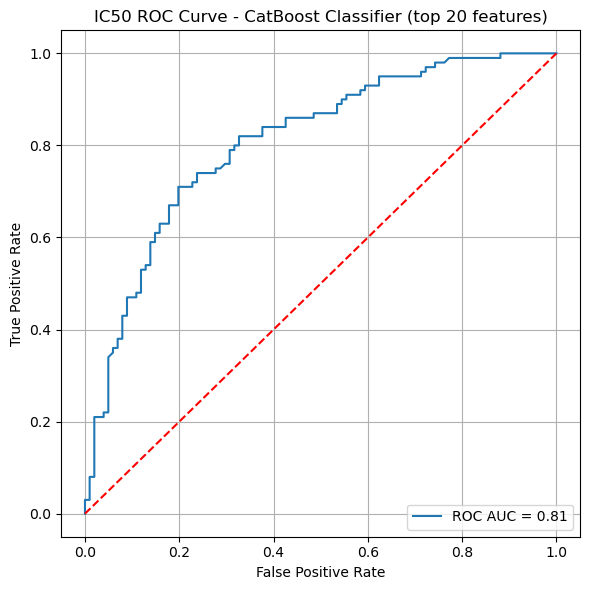


Модель сохранена как 'IC50_classifier_catboost_final_model_top20.pkl'


In [15]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMRegressor
import joblib

# --- 0. Подготовка датафрейма ---
df_cut = df_cut.copy()  # чтобы log_CC50 не терялся

# --- 1. Добавление признака log_CC50 с использованием LightGBM регрессионной модели ---
reg_model_cc50 = joblib.load('regression_CC50_lightgbm_final_model_df_to_IC50_class.pkl')

cc50_model_features = reg_model_cc50.feature_name_
missing_features = [feat for feat in cc50_model_features if feat not in df_cut.columns]
if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки для модели CC50: {missing_features}")

X_cc50 = df_cut[cc50_model_features].copy()
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_cc50_imputed = pd.DataFrame(imputer_cc50.fit_transform(X_cc50), columns=cc50_model_features)

scaler_cc50 = RobustScaler()
X_cc50_scaled = pd.DataFrame(scaler_cc50.fit_transform(X_cc50_imputed), columns=cc50_model_features)

log_cc50_pred = reg_model_cc50.predict(X_cc50_scaled)
df_cut['log_CC50'] = log_cc50_pred
df_cut['CC50'] = 10**df_cut['log_CC50']
# Добавляем ранги
df_cut['CC50_rank'] = df_cut['CC50'].rank(method='average')
df_cut['CC50_percentile'] = df_cut['CC50'].rank(pct=True)




# --- 2. Подготовка данных для классификации IC50 ---
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 3. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 4. Обучение модели на всех признаках, получение важности ---
y_full = (IC50 > IC50.median()).astype(int)

cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled, y_full)

feature_importances = cat_model_full.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Выбираем топ-20 признаков
top_20_features = feat_imp_df['Feature'].iloc[:96].tolist()

print(f"Top 20 features:\n{top_20_features}")

# --- 5. Используем только топ-20 признаков ---
X_selected = X_scaled[top_20_features]

# --- 6. Кросс-валидация с топ-20 признаками ---
kf = KFold(n_splits=6, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("\nRunning 10-fold cross-validation with top 20 features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_selected), 1):
    X_train_cv, X_val_cv = X_selected.iloc[train_index], X_selected.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results (top 50 features):")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 7. Разделение на train/test ---
median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_selected, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

ic50_train = IC50.loc[idx_train]
ic50_test = IC50.loc[idx_test]

print(f"\nTrain IC50 median: {ic50_train.median():.4f}")
print(f"Test  IC50 median: {ic50_test.median():.4f}")

# --- 8. Обучение финальной модели на топ-20 признаках ---
cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_train, y_train)

y_pred = cat_model_final.predict(X_test)
y_proba = cat_model_final.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 9. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost Classifier (top 20 features)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifier_roc_curve_top20.png")
plt.show()

# --- 10. Сохранение модели ---
joblib.dump(cat_model_final, 'IC50_classifier_catboost_final_model_top20.pkl')
print("\nМодель сохранена как 'IC50_classifier_catboost_final_model_top20.pkl'")


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMRegressor
import joblib

# --- 0. Подготовка датафрейма ---
df_cut = df_cut.copy()

# --- 1. Добавление признака log_CC50 с использованием LGBM ---
reg_model_cc50 = joblib.load('regression_CC50_lightgbm_final_model_df_to_IC50_class.pkl')

cc50_model_features = reg_model_cc50.feature_name_
missing_features = [feat for feat in cc50_model_features if feat not in df_cut.columns]
if missing_features:
    raise ValueError(f"Отсутствуют необходимые признаки для модели CC50: {missing_features}")

X_cc50 = df_cut[cc50_model_features].copy()
imputer_cc50 = SimpleImputer(strategy='most_frequent')
X_cc50_imputed = pd.DataFrame(imputer_cc50.fit_transform(X_cc50), columns=cc50_model_features)

scaler_cc50 = RobustScaler()
X_cc50_scaled = pd.DataFrame(scaler_cc50.fit_transform(X_cc50_imputed), columns=cc50_model_features)

log_cc50_pred = reg_model_cc50.predict(X_cc50_scaled)
df_cut['log_CC50'] = log_cc50_pred
df_cut['CC50'] = 10**df_cut['log_CC50']
df_cut['CC50_rank'] = df_cut['CC50'].rank(method='average')
df_cut['CC50_percentile'] = df_cut['CC50'].rank(pct=True)

# --- 2. Подготовка данных для классификации IC50 ---
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# --- 3. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 4. Обучение модели и получение важности ---
y_full = (IC50 > IC50.median()).astype(int)

cat_model_full = CatBoostClassifier(**catboost_params)
cat_model_full.fit(X_scaled, y_full)

feature_importances = cat_model_full.get_feature_importance(Pool(X_scaled, label=y_full))
feat_imp_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# --- 5. Цикл по topN_features от 16 до 66 ---
print("Прогон по topN признакам от 16 до 66...\n")
for N in range(40, 100):
    topN_features = feat_imp_df['Feature'].head(N).tolist()
    X_selected = X_scaled[topN_features]

    # Разделение на train/test
    median_ic50_global = IC50.median()
    y_binary = (IC50 > median_ic50_global).astype(int)

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_selected, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
    )

    # Обучение модели
    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc_test = accuracy_score(y_test, y_pred)
    roc_auc_test = roc_auc_score(y_test, y_proba)

    # Вывод
    print(f"head: {N}")
    print(f"Test Accuracy: {acc_test:.4f}")
    print(f"Test ROC AUC:  {roc_auc_test:.4f}\n")


- c log(CC50) и PCA

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib
from tqdm import tqdm  # для индикатора прогресса (если не установлен, можно убрать)

# --- 0. Подготовка датафрейма ---
df_cut = df_cut.copy()  # если df_cut уже есть

# --- 1. Подготовка данных ---
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Подбор PCA по ROC AUC (от максимального числа признаков к 1) ---
print("\n Подбор количества компонент PCA по ROC AUC (сверху вниз)...")
X_array = X_scaled.values
max_components = X_array.shape[1]
roc_auc_scores = []

for n in tqdm(range(max_components, 0, -1)):  # от max к 1
    pca = PCA(n_components=n, random_state=42)
    X_pca_temp = pca.fit_transform(X_array)

    X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(
        X_pca_temp, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train_pca, y_train_pca)
    y_proba = model.predict_proba(X_val_pca)[:, 1]
    auc = roc_auc_score(y_val_pca, y_proba)
    roc_auc_scores.append((n, auc))

best_n_pca, best_auc = max(roc_auc_scores, key=lambda x: x[1])
print(f"\nЛучшее количество компонент PCA: {best_n_pca}")
print(f" ROC AUC на валидации: {best_auc:.4f}")

# --- График зависимости ROC AUC от числа компонент ---
components, scores = zip(*roc_auc_scores)
plt.figure(figsize=(10, 6))
plt.plot(components, scores, marker='o')
plt.xlabel("Число компонент PCA")
plt.ylabel("ROC AUC")
plt.title("Подбор количества компонент PCA по ROC AUC (сверху вниз)")
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_roc_auc_optimization.png")
plt.show()

# --- 4. Обновляем данные на PCA-признаках с оптимальным числом компонент ---
pca_final = PCA(n_components=best_n_pca, random_state=42)
X_pca = pd.DataFrame(pca_final.fit_transform(X_array), index=X.index)
print(f"PCA reduced the data from {X_scaled.shape[1]} to {X_pca.shape[1]} components.")

# --- 5. Кросс-валидация на PCA-признаках ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("\nRunning 10-fold cross-validation on PCA features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_pca), 1):
    X_train_cv, X_val_cv = X_pca.iloc[train_index], X_pca.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 6. Разделение и оценка на тесте ---
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_pca, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

ic50_train = IC50.loc[idx_train]
ic50_test = IC50.loc[idx_test]

print(f"\nTrain IC50 median: {ic50_train.median():.4f}")
print(f"Test  IC50 median: {ic50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 7. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost Classifier with PCA")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifier_roc_curve_pca.png")
plt.show()

# --- 8. Важность признаков (на исходных признаках без PCA) ---
cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_binary)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_binary))
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("IC50 Top 30 Feature Importances - CatBoost (Original Features)")
plt.tight_layout()
plt.savefig("IC50_classification_feature_importance.png")
plt.show()

# --- 9. Сохранение модели (на PCA-признаках) ---
cat_model_final_pca = CatBoostClassifier(**catboost_params)
cat_model_final_pca.fit(X_pca, y_binary)

joblib.dump(cat_model_final_pca, 'IC50_classifier_catboost_final_model_pca.pkl')
print("\nМодель с PCA сохранена как 'IC50_classifier_catboost_final_model_pca.pkl'")


- c log(CC50) и UMAP

In [ ]:
!pip install umap-learn

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import joblib
from tqdm import tqdm
import umap

# --- 0. Подготовка датафрейма ---
df_cut = df_cut.copy()  # если df_cut уже есть

# --- 1. Подготовка данных ---
df_cut.columns = df_cut.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
df_cut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cut.drop(columns=['IC50_above_median'], errors='ignore', inplace=True)

ic50_columns = [col for col in df_cut.columns if 'ic50' in col.lower()]
if not ic50_columns:
    raise ValueError("Нет колонки, содержащей 'IC50' в названии.")
ic50_col = ic50_columns[0]

IC50 = df_cut[ic50_col]
X = df_cut.drop(columns=[ic50_col])

imputer = SimpleImputer(strategy='most_frequent')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

median_ic50_global = IC50.median()
y_binary = (IC50 > median_ic50_global).astype(int)

# --- 2. Параметры модели ---
catboost_params = {
    'depth': 6,
    'iterations': 100,
    'l2_leaf_reg': 5,
    'learning_rate': 0.05,
    'verbose': 0,
    'random_state': 42
}

# --- 3. Подбор UMAP по ROC AUC ---
print("\nПодбор количества компонент UMAP по ROC AUC (сверху вниз)...")
X_array = X_scaled.values
max_components = X_array.shape[1]
roc_auc_scores_umap = []

for n in tqdm(range(max_components, 1, -1)):
    reducer = umap.UMAP(n_components=n, random_state=42)
    X_umap_temp = reducer.fit_transform(X_array)

    X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(
        X_umap_temp, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )

    model = CatBoostClassifier(**catboost_params)
    model.fit(X_train_u, y_train_u)
    y_proba = model.predict_proba(X_val_u)[:, 1]
    auc = roc_auc_score(y_val_u, y_proba)
    roc_auc_scores_umap.append((n, auc))

best_n_umap, best_auc_umap = max(roc_auc_scores_umap, key=lambda x: x[1])
print(f"\nЛучшее количество компонент UMAP: {best_n_umap}")
print(f" ROC AUC на валидации: {best_auc_umap:.4f}")

components_u, scores_u = zip(*roc_auc_scores_umap)
plt.figure(figsize=(10, 6))
plt.plot(components_u, scores_u, marker='o')
plt.xlabel("Число компонент UMAP")
plt.ylabel("ROC AUC")
plt.title("Подбор количества компонент UMAP по ROC AUC")
plt.grid(True)
plt.tight_layout()
plt.savefig("umap_roc_auc_optimization.png")
plt.show()

# --- 4. Преобразование с UMAP ---
reducer_final = umap.UMAP(n_components=best_n_umap, random_state=42)
X_umap = pd.DataFrame(reducer_final.fit_transform(X_array), index=X.index)
print(f"UMAP reduced the data from {X_scaled.shape[1]} to {X_umap.shape[1]} components.")

# --- 5. Кросс-валидация ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_list, roc_auc_list = [], []

print("\nRunning 10-fold cross-validation on UMAP features...")

for fold, (train_index, val_index) in enumerate(kf.split(X_umap), 1):
    X_train_cv, X_val_cv = X_umap.iloc[train_index], X_umap.iloc[val_index]
    ic50_train = IC50.iloc[train_index]
    ic50_val = IC50.iloc[val_index]

    median_ic50 = ic50_train.median()
    y_train_cv = (ic50_train > median_ic50).astype(int)
    y_val_cv = (ic50_val > median_ic50).astype(int)

    model_cv = CatBoostClassifier(**catboost_params)
    model_cv.fit(X_train_cv, y_train_cv)

    y_pred_cv = model_cv.predict(X_val_cv)
    y_proba_cv = model_cv.predict_proba(X_val_cv)[:, 1]

    acc = accuracy_score(y_val_cv, y_pred_cv)
    roc_auc = roc_auc_score(y_val_cv, y_proba_cv)

    accuracy_list.append(acc)
    roc_auc_list.append(roc_auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}, ROC AUC: {roc_auc:.4f}")

print("\nCross-validation results:")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"ROC AUC:  {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}")

# --- 6. Разделение и оценка на тесте ---
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_umap, y_binary, IC50.index, test_size=0.2, random_state=42, stratify=y_binary
)

ic50_train = IC50.loc[idx_train]
ic50_test = IC50.loc[idx_test]

print(f"\nTrain IC50 median: {ic50_train.median():.4f}")
print(f"Test  IC50 median: {ic50_test.median():.4f}")

cat_model_eval = CatBoostClassifier(**catboost_params)
cat_model_eval.fit(X_train, y_train)

y_pred = cat_model_eval.predict(X_test)
y_proba = cat_model_eval.predict_proba(X_test)[:, 1]

acc_test = accuracy_score(y_test, y_pred)
roc_auc_test = roc_auc_score(y_test, y_proba)

print("\nClassification report:")
print(classification_report(y_test, y_pred))
print(f"Test Accuracy: {acc_test:.4f}")
print(f"Test ROC AUC:  {roc_auc_test:.4f}")

# --- 7. ROC AUC график ---
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_test:.2f}")
plt.plot([0, 1], [0, 1], '--r')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IC50 ROC Curve - CatBoost Classifier with UMAP")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("IC50_classifier_roc_curve_umap.png")
plt.show()

# --- 8. Важность признаков на исходных данных ---
cat_model_final = CatBoostClassifier(**catboost_params)
cat_model_final.fit(X_scaled, y_binary)

feature_importances = cat_model_final.get_feature_importance(Pool(X_scaled, label=y_binary))
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(30))
plt.title("IC50 Top 30 Feature Importances - CatBoost (Original Features)")
plt.tight_layout()
plt.savefig("IC50_classification_feature_importance.png")
plt.show()

# --- 9. Сохранение модели ---
cat_model_final_umap = CatBoostClassifier(**catboost_params)
cat_model_final_umap.fit(X_umap, y_binary)

joblib.dump(cat_model_final_umap, 'IC50_classifier_catboost_final_model_umap.pkl')
print("\nМодель с UMAP сохранена как 'IC50_classifier_catboost_final_model_umap.pkl'")
